In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
from sklearn import linear_model
import seaborn as sb


In [9]:
path = "./loan.csv"
inputDf = pd.read_csv(path, ",")

In [10]:
#selectedCols = inputDf[["loan_amnt", "funded_amnt", "term", "int_rate", "grade", "annual_inc", "issue_d",
#"dti", "revol_bal", "total_pymnt", "loan_status"]]
selectedCols = inputDf
selectedCols.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### parse data into numeric where possible

In [11]:
termDummies = pd.get_dummies(selectedCols["term"])
selectedCols = termDummies.join(selectedCols.drop(columns = ["term"]))
selectedCols.head()

,36 months,60 months,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1,0,1077501,1296599,5000.0,5000.0,4975.0,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1077430,1314167,2500.0,2500.0,2500.0,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,1077175,1313524,2400.0,2400.0,2400.0,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,1076863,1277178,10000.0,10000.0,10000.0,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,1075358,1311748,3000.0,3000.0,3000.0,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
selectedCols["origYear"] = selectedCols["issue_d"].str.extract("\w{3}-(\d{4})")
selectedCols = selectedCols.drop(columns= ["issue_d"])

In [13]:
typedDf = selectedCols

# Part One - Data Exploration

In [14]:
# looking at data types
typedDf.dtypes

 36 months                       uint8
 60 months                       uint8
id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

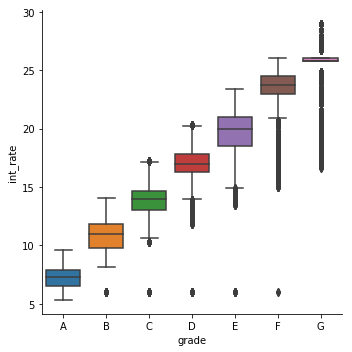

In [15]:
sb.catplot(x="grade", y="int_rate", data=typedDf, kind="box", order = ("A", "B", "C", "D", "E", "F","G"))
## worried that grades and interest rates lead to multicolinearity problems
## also notice that all grades except A and G have some sort of 'outlier' interest rate at 5%.

In [16]:
# convert grades to numerics
gradeDummies = pd.get_dummies(selectedCols["grade"], prefix="grade")
selectedColsNoGrade = typedDf.drop(columns=["grade"])
dummiedGradesDf = gradeDummies.join(selectedColsNoGrade)

In [17]:
dummiedGradesDf["grade"] = dummiedGradesDf["grade_A"] * 0 + \
    dummiedGradesDf["grade_B"] * 2 + dummiedGradesDf["grade_C"] * 3 + dummiedGradesDf["grade_D"] * 4  + \
    dummiedGradesDf["grade_E"] * 5 + dummiedGradesDf["grade_F"] * 6 + dummiedGradesDf["grade_G"] * 6
dummiedGradesDf = dummiedGradesDf.drop(columns=["grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G"])

In [18]:
typedDf = dummiedGradesDf

### Look at Correlations

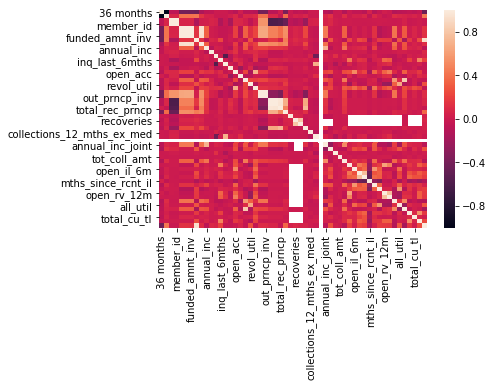

In [19]:
sb.heatmap(typedDf.corr())

funded amt and loan amount are highly correlated

interest rate and grade highly correlated (as seen above in box/whisker)

### look at distributions

In [20]:
### everything is skewed right, except grade which is perfectly balanced
### DTI seems to have an outlier, or is 9999 a null placeholder ?
normalized = typedDf.copy(deep = True)
normalized.describe()

,36 months,60 months,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,grade
count,887379.000000,887379.000000,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,...,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000,887379.000000
mean,0.699955,0.300045,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,...,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307,2.625206
std,0.458278,0.458278,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,...,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067,1.553977
min,0.000000,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000,0.000000
25%,0.000000,0.000000,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,...,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000,2.000000
50%,1.000000,0.000000,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,...,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000,3.000000
75%,1.000000,1.000000,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,...,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000,4.000000
max,1.000000,1.000000,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,...,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000,6.000000


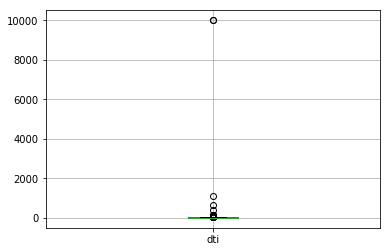

In [21]:
#looks like dti= 9999 is a null placeholder because there are few values between ~ 100 and that 9999 value
dti = typedDf[["dti"]]
boxplot = dti.boxplot(column=['dti'])

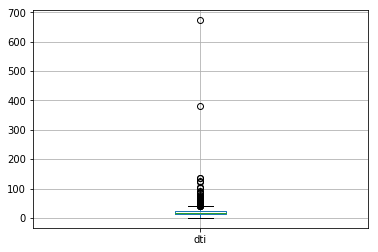

In [22]:
#looks much better if we remove 9999 - still heavily skewed though.
boxplot = dti[dti["dti"] < 900 ].boxplot(column=['dti'])

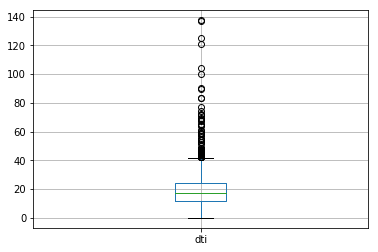

In [23]:
# much nicer if we remove outliers ( > 300)
boxplot = dti[dti["dti"] < 300].boxplot(column=['dti'])

In [24]:
typedDf = typedDf[typedDf["dti"] < 300]

In [25]:
def normalize(df, col):
    ser = df[[col]]
    normalized_ser=(ser-ser.min())/(ser.max()-ser.min())
    df.drop(columns=[col])
    df[col] = normalized_ser
    return df

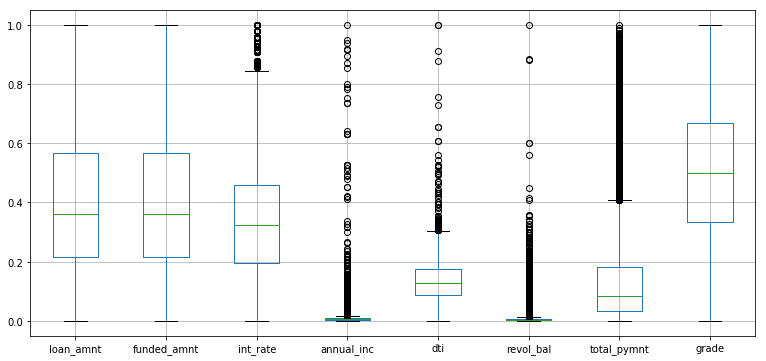

In [26]:
normalizeDf = typedDf.copy(deep = True)
normalize(normalizeDf, "loan_amnt")
normalize(normalizeDf, "funded_amnt")
normalize(normalizeDf, "int_rate")
normalize(normalizeDf, "annual_inc")
normalize(normalizeDf, "dti")
normalize(normalizeDf, "revol_bal")
normalize(normalizeDf, "total_pymnt")
normalize(normalizeDf, "grade")
normalizeDf.boxplot(column=["loan_amnt", "funded_amnt", "int_rate", "annual_inc",
                                  "dti", "revol_bal", "total_pymnt", "grade"], figsize=(13,6))

In [27]:
#Confirms suspicions of bad skew.
# annual income being the worst offender. nothing to do now other than just keep note for later stages
typedDf.skew(axis = 0)

 36 months                      -0.872634
 60 months                       0.872634
id                               0.023912
member_id                        0.017419
loan_amnt                        0.681683
funded_amnt                      0.683745
funded_amnt_inv                  0.680983
int_rate                         0.429490
installment                      0.936954
annual_inc                      44.478835
dti                              0.247207
delinq_2yrs                      5.473848
inq_last_6mths                   2.108407
mths_since_last_delinq           0.455517
mths_since_last_record          -0.198568
open_acc                         1.249379
pub_rec                         13.261911
revol_bal                       15.949282
revol_util                      -0.123866
total_acc                        0.892526
out_prncp                        0.932024
out_prncp_inv                    0.931874
total_pymnt                      1.788890
total_pymnt_inv                  1

# Part Two - Business Analysis
#### footnote - this did not say to balance weight, but this should be balance weighted

In [28]:
##only look at 36 month loans
shortTerm = typedDf[typedDf[" 36 months"] == 1]


In [29]:
shortTerm.loan_status.value_counts()

Current                                                402844
Fully Paid                                             167575
Charged Off                                             29083
Late (31-120 days)                                       7026
Issued                                                   5982
In Grace Period                                          3975
Does not meet the credit policy. Status:Fully Paid       1789
Late (16-30 days)                                        1483
Default                                                   715
Does not meet the credit policy. Status:Charged Off       649
Name: loan_status, dtype: int64

In [30]:
##only look at loans that are no longer alive 
# assuming that if they are done paying they are in one of three categories below
# not sure what: "Does not meet the credit policy. Status:Charged Off", "Does not meet the credit policy. Status:Charged Off"
shortTerm = shortTerm[(shortTerm["loan_status"] == "Fully Paid") | (shortTerm["loan_status"] == "Charged Off") | 
                    (shortTerm["loan_status"] == "Default")]

#### Pct loans fully paid ?

In [31]:
statuses = shortTerm["loan_status"].value_counts()
counts = statuses
relFreqs = statuses /shortTerm.size
fullyPaidIndex = 1
print("there are {} loans fully paid, which represents {} loans".format(counts[fullyPaidIndex], relFreqs[fullyPaidIndex]))

there are 29083 loans fully paid, which represents 0.0019646726418169323 loans


#### highest rates of default ? 

In [32]:
defaultDf = shortTerm[["origYear", "grade", "loan_status"]]

In [33]:
statusDummies = pd.get_dummies(defaultDf["loan_status"])
defaultDf["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
defaultGroupings = defaultDf.groupby(['origYear', 'grade']).mean()
cohorts = defaultGroupings.sort_values(by = "defaulted", ascending = False)
#defaultGroupings.unstack()
maxDefaults = cohorts.iloc[:1,]
print(maxDefaults)
print("the highest default rate of 0.5 was found among 2008 G's !")

                defaulted
origYear grade           
2008     6           0.48
the highest default rate of 0.5 was found among 2008 G's !


### annualized rate of return

In [35]:
rateReturn = shortTerm

In [36]:
rateReturn["annualizedRateReturn"] = np.power((rateReturn["total_pymnt"] / rateReturn["funded_amnt"]), 1/3) - 1

In [37]:
rateReturn = rateReturn[["annualizedRateReturn", "origYear", "grade"]]

In [38]:
rateReturn.head()

,annualizedRateReturn,origYear,grade
0,0.054393,2011,2
2,0.077654,2011,3
3,0.069297,2011,3
5,0.040435,2011,0
7,0.094940,2011,5


In [39]:
returnCohorts = rateReturn.groupby(['origYear', 'grade']).mean()
returnCohorts = returnCohorts.sort_values(by = "annualizedRateReturn", ascending = False)

#### below is a summary of the annualized rate of return for each cohort (grouped by origination year and grade)

In [40]:
rateReturn.groupby(['origYear', 'grade']).mean().unstack()

annualizedRateReturn                                          \
grade                       0         2         3         4         5   
origYear                                                                
2007                 0.027176  0.012265  0.012208 -0.023199 -0.009098   
2008                 0.025285  0.009916  0.009593 -0.010402  0.022560   
2009                 0.021317  0.017141  0.014591  0.018891  0.002592   
2010                 0.021648  0.023139  0.024831  0.023060  0.018264   
2011                 0.014910  0.021848  0.017563  0.021422  0.024065   
2012                 0.015651  0.023376  0.021841  0.023836  0.031327   
2013                 0.011632  0.006965 -0.002854 -0.014875 -0.026810   
2014                -0.002589 -0.013946 -0.037361 -0.057194 -0.079325   
2015                -0.012722 -0.026685 -0.043013 -0.071553 -0.108845   

                    
grade            6  
origYear            
2007      0.031161  
2008     -0.071268  
2009      0.030043  
2010     -0.010835  
2011      0.015600  
2012      0.034269  
2013     -0.045979  
2014     -0.094071  
2015     -0.134226

# Part 3 - Modeling

In [61]:
modelDf = typedDf.copy(deep = True)
modelDf.head()

,36 months,60 months,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,origYear,grade
0,1,0,1077501,1296599,5000.0,5000.0,4975.0,10.65,162.87,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,2
1,0,1,1077430,1314167,2500.0,2500.0,2500.0,15.27,59.83,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
2,1,0,1077175,1313524,2400.0,2400.0,2400.0,15.96,84.33,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
3,1,0,1076863,1277178,10000.0,10000.0,10000.0,13.49,339.31,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,3
4,0,1,1075358,1311748,3000.0,3000.0,3000.0,12.69,67.79,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,2


### first pass using the variables used in data analysis thus far

In [49]:
firstPassRegression = modelDf[["loan_amnt", " 60 months", "int_rate", "annual_inc", 
         "dti", "revol_bal", "total_pymnt", "loan_status"]]

### create features / labels

In [50]:
firstPassRegression = firstPassRegression[(firstPassRegression["loan_status"] == "Fully Paid") |
                                          (firstPassRegression["loan_status"] == "Charged Off") |
                                          (firstPassRegression["loan_status"] == "Default")]
statusDummies = pd.get_dummies(firstPassRegression["loan_status"])
firstPassRegression["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

In [53]:
labels = firstPassRegression["defaulted"]
features = firstPassRegression.drop(columns=["defaulted", "loan_status"])
features.head()

,loan_amnt,60 months,int_rate,annual_inc,dti,revol_bal,total_pymnt
0,5000.0,0,10.65,24000.0,27.65,13648.0,5861.071414
1,2500.0,1,15.27,30000.0,1.00,1687.0,1008.710000
2,2400.0,0,15.96,12252.0,8.72,2956.0,3003.653644
3,10000.0,0,13.49,49200.0,20.00,5598.0,12226.302212
5,5000.0,0,7.90,36000.0,11.20,7963.0,5631.377753


### split train and test

In [54]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

### Establish Baseline

In [55]:
from sklearn.dummy import DummyClassifier
freqentist = DummyClassifier(strategy='most_frequent')
freqentist.fit(train_features, train_labels)
print("baseline prediction accuracy is {}".format(freqentist.score(test_features, test_labels).round(4)))

baseline prediction accuracy is 0.8163


### Try multivariate linear regression

In [56]:
ols = linear_model.LinearRegression(normalize = False)
model = ols.fit(train_features, train_labels)

In [57]:
print("OLS regression has an R^2 of {}".format(model.score(test_features, test_labels).round(4)))

OLS regression has an R^2 of 0.5943



#### this is pretty bad... lets work harder on variable selection

In [65]:
modelDf.dtypes

 36 months                       uint8
 60 months                       uint8
id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
int_rate                       float64
installment                    float64
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line         

In [ ]:
emp_length                      object
home_ownership

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [58]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [59]:
SelectKBest(f_regression).fit_transform(train_features, train_labels)

ValueError: k should be >=0, <= n_features = 7; got 10. Use k='all' to return all features.

In [ ]:
f_regression(train_features, train_labels)

In [ ]:
train_features.head()